# Sklearn

## Bike Sharing Demand Problem
The problem at [kaggle.com](https://www.kaggle.com/c/bike-sharing-demand).
Based on historical data on bicycle rental and weather conditions, it is necessary to evaluate the demand for bicycle rental.

In the original problem statement, there are 11 features available: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

The feature set contains both real, categorical, and binary data.

For the demonstration, a training sample bike_sharing_demand.csv is used from the original data.

Задача на kaggle: 
По историческим данным о прокате велосипедов и погодным условиям необходимо оценить спрос на прокат велосипедов.
В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data
В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 
Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются.



In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Libraries

In [1]:
from sklearn import model_selection, linear_model, metrics

import numpy as np
import pandas as pd

In [112]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Dataset load
We load data into dataframe. 

In [4]:
raw_data = pd.read_csv('bike_sharing_demand.csv', header = 0, sep = ',')

In [5]:
raw_data.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***casual*** - number of non-registered user rentals initiated

***registered*** - number of registered user rentals initiated

***count*** - number of total bike rentals, **the target label**

In [6]:
print(raw_data.shape)

(10886, 12)


Let us check is any **values that are missing** in dataset. If so, we need to process to fill them in.

In [7]:
raw_data.isnull().values.any()

False

The negative result shows there are no missed data cells/ values.

### Data preprocessing

#### Типы признаков

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


We may see here that almost all the data are presented as numbers, whether integers or floating point ones.
#### Transform into the *datetime* type
So, let's transform **datetime** feature (of a type *object*) into the *datetime* type in the dataframe:

In [111]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)
raw_data.sample(3)

datetime  season  holiday  workingday  weather   temp   atemp  \
4320 2011-10-12 01:00:00       4        0           1        3  22.96  26.515   
7355 2012-05-05 20:00:00       2        0           0        1  24.60  28.790   
9854 2012-10-14 23:00:00       4        0           0        2  22.96  26.515   

      humidity  windspeed  casual  registered  count  month  hour  
4320        83     8.9981       2           8     10     10     1  
7355        78    16.9979     100         209    309      5    20  
9854        68    19.0012      27          78    105     10    23

#### 2 new features from datetime
Based on that transformed feature we calculate 2 new features: **month** and **hour** of the event (rental).

In [13]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

In [15]:
raw_data.sample(3)

datetime  season  holiday  workingday  weather   temp   atemp  \
6864 2012-04-04 08:00:00       2        0           1        2  18.04  21.970   
6290 2012-02-18 08:00:00       1        0           0        1   9.02  13.635   
3765 2011-09-07 20:00:00       3        0           1        3  26.24  28.790   

      humidity  windspeed  casual  registered  count  month  hour  
6864        72     7.0015      31         653    684      4     8  
6290        87     0.0000      10          92    102      2     8  
3765        89     6.0032       3          93     96      9    20

#### Splitting the model into the train and test sets.
Note that the data are **time dependent**, **time spread**. So we might get the train data of earlier period and evaluate the built estimator on the test set of later period. Since the data are sorted by time, we just cut of the last 1000 rows and use them as a test set.  

In [16]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [17]:
print(raw_data.shape, train_data.shape, hold_out_test_data.shape)

(10886, 14) (9886, 14) (1000, 14)


In [18]:
print('train period from {} to {}'.format(train_data.datetime.min(), train_data.datetime.max()))
print('evaluation period from {} to {}'.format(hold_out_test_data.datetime.min(), hold_out_test_data.datetime.max()))

train period from 2011-01-01 00:00:00 to 2012-10-16 06:00:00
evaluation period from 2012-10-16 07:00:00 to 2012-12-19 23:00:00


#### Data and target function
We cut off the target, column **count** from the rest of dataset.

We also cut off the **datetime** data column since it's now only an object identifier.

In [20]:
# training dataset
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count'], axis = 1)

In [19]:
# test dataset
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count'], axis = 1)

#### Let's visualize the target function (label) at the train and test sets.
Remember that target label (**count**) shows how many bikes were rented at that time spot (hour).

Text(0.5, 1.0, 'test data')

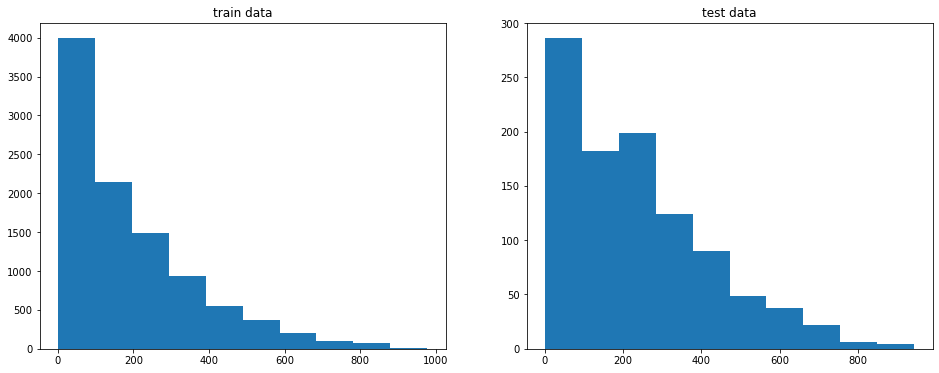

In [21]:
pylab.figure(figsize = (16, 6))

pylab.subplot(1,2,1)
pylab.hist(train_labels)
pylab.title('train data')

pylab.subplot(1,2,2)
pylab.hist(test_labels)
pylab.title('test data')

#### Numeric features
In this post we work only with numeric features. Let's separate them.

In [110]:
numeric_columns = ['temp', 'atemp', 'humidity',\
'windspeed', 'casual', 'registered', 'month', 'hour']

In [23]:
train_data = train_data[numeric_columns]
test_data = test_data[numeric_columns]

In [24]:
train_data.head()

temp   atemp  humidity  windspeed  casual  registered  month  hour
0  9.84  14.395        81        0.0       3          13      1     0
1  9.02  13.635        80        0.0       8          32      1     1
2  9.02  13.635        80        0.0       5          27      1     2
3  9.84  14.395        75        0.0       3          10      1     3
4  9.84  14.395        75        0.0       0           1      1     4

### We now train a model with SGDRegressor
SGDRegressor develops a model based on [Stochastic Gradient Descent](/linear-regression-stochastic-gradient-descent/).

We supply the default paramets for the regressor model.

In [26]:
regressor = linear_model.SGDRegressor(random_state = 0, max_iter=5)
regressor.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 5,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': 0,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

1. Train the model `regressor.fit()` 
2. Estimate the model with MAE `mean_absolute_error`

In [27]:
regressor.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(test_data))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


9340385490952.236

The number is too big...

Let's output the targets and model predictions:

In [33]:
print('Target\n', test_labels[:10])

Target
 [525 835 355 222 228 325 328 308 346 446]


In [32]:
print('Prediction\n', regressor.predict(test_data)[:10])

Prediction
 [1.47320172e+13 2.64787988e+13 1.23495857e+13 1.35429951e+13
 1.25998915e+13 1.74809610e+13 1.75786549e+13 2.11426913e+13
 1.96417926e+13 2.32672606e+13]


The model predicts super big numbers. It should not be this way.

Let's take a look at the regression coefficients.

In [34]:
regressor.coef_

array([ 1.12866511e+10,  6.68434729e+10, -7.05920006e+10, -2.09051100e+10,
        1.65497847e+11,  2.92967602e+10, -6.71456293e+10,  8.32559786e+10])

The regression model coefficients are too high. This might happen if the features differ in scale. 
### Scaling the features

In [35]:
from sklearn.preprocessing import StandardScaler

We separately apply **StandardScaler** to the train and test data.

In [37]:
# create StandardScaler and train/fit it
scaler = StandardScaler()
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

After we've got scaled data we train the model again.

In [38]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


0.11793762963431514

The error is in this case is very low. 

If we output targets and predictions (below), we see that the model has done a good estimation. The distance is less than 1 bike.

In [39]:
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [45]:
list(map(lambda x : round(x, 2), regressor.predict(scaled_test_data)[:10]))

[524.83, 834.83, 354.86, 221.89, 227.84, 324.88, 327.9, 307.93, 345.9, 445.9]

### The regression result is suspiciously good
We take a look at the coefficients and see that almost all of the weights are too small.

In [64]:
#print(regressor.coef_)
map_obj = map(lambda x : round(x, 2), regressor.coef_)
print('regressor.coef_\n', list(map_obj))

regressor.coef_
 [1.41, -1.41, 0.01, -0.04, 50.86, 148.0, -0.01, 0.01]


What are the features with non-small weights, 50.86, 148.0  ? 

*Casual* and *register* features are.

#### How does the bike rental system work?
The bike rental system works as follows: both registered and unregistered users can use the system. In this case, column **registered** represent the number of registered users who use the system. The **casual** column shows the number of users who have not registered but also want to rent a bike. 

Let's output the values of the target function and see the following pattern: if the **value of these two columns (*registered* and *casual*) is added together, we get our target label**.

In [55]:
train_labels[:10]

array([16, 40, 32, 13,  1,  1,  2,  3,  8, 14], dtype=int64)

In [65]:
np.all(train_data.registered + train_data.casual == train_labels)

True

This was our mistake. We indeed used the features in dataset (**casual**, **registered**) that replicate the target, **count**. 

So we cut off these data (columns) from train and test sets to properly build regession model.

In [106]:
train_data.drop(['casual', 'registered'], axis = 1, inplace = True)
test_data.drop(['casual', 'registered'], axis = 1, inplace = True)

KeyError: "['casual' 'registered'] not found in axis"

We scale the features with the new dataset and train/fit the model and estimate by MAE.

In [72]:
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [73]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


121.81123864993025

The above MAE is more realistic.

The all model weights are influence the model predictions.

In [74]:
print(list(map(lambda x : round(x, 2), regressor.coef_)))

[31.03, 29.96, -41.93, 6.17, 14.08, 49.6]


### Pipeline

Up to now we were solving the problem with default parameters of the regressor model. Now we have a certain base-level model.

Now we will select optimal parameters for a regressor model.

Yet to train/fit the model we need to scale [only] a train dataset. Since we use cross-validation (CV) we'll need to scale each CV training dataset at each CV step. Therefore we make a **Pipeline**. Pipeline implies transformation chains. Particulary it'll include 2 chains: (1) scaling and (2) regressotion itself at each iteration. *Sklearn* library does allow us to do both scaling of at each iteration and CV thru **Pipeline** module.

In [75]:
from sklearn.pipeline import Pipeline

In [76]:
# make a pipeline from two steps: scaling and classification
pipeline = Pipeline(steps = [('scaling', scaler), ('regression', regressor)])
# both methods `scaler` and `regressor` should posess methods fit() and perdict()

In [78]:
pipeline.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, pipeline.predict(test_data))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


121.81123864993025

The error (above) remained the same. Pipeline works well.
### Parameters selection
We select parameters by grid. 

In the case of using Pipeline, we need to refer to the model parameters using the extended name. 

First, we need to specify the name of the step, then a double underscore goes, then the name of the parameter itself follows.

In [79]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaling', 'regression', 'scaling__copy', 'scaling__with_mean', 'scaling__with_std', 'regression__alpha', 'regression__average', 'regression__early_stopping', 'regression__epsilon', 'regression__eta0', 'regression__fit_intercept', 'regression__l1_ratio', 'regression__learning_rate', 'regression__loss', 'regression__max_iter', 'regression__n_iter_no_change', 'regression__penalty', 'regression__power_t', 'regression__random_state', 'regression__shuffle', 'regression__tol', 'regression__validation_fraction', 'regression__verbose', 'regression__warm_start'])

We compose a dictionary of parameters to choose from.

In [90]:
parameters_grid = {
    'regression__loss' : ['huber', 'epsilon_insensitive', 'squared_loss', ],
    'regression__max_iter' : [3, 5, 10, 50], 
    'regression__penalty' : ['l1', 'l2', 'none'],
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0., 0.5], #
}

We build a CV grid and pass the **pipeline** object into it along with **parameters_grid** and others.

 - Parameter **scoring** defines the kind of error that we score parameters at.

In [91]:
grid_cv = model_selection.GridSearchCV(pipeline, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [92]:
%%time
grid_cv.fit(train_data, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

Wall time: 22.6 s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('regression',
                                        SGDRegressor(max_iter=5,
                                                     random_state=0))]),
             param_grid={'regression__alpha': [0.0001, 0.01],
                         'regression__loss': ['huber', 'epsilon_insensitive',
                                              'squared_loss'],
                         'regression__max_iter': [3, 5, 10, 50],
                         'regression__penalty': ['l1', 'l2', 'none'],
                         'scaling__with_mean': [0.0, 0.5]},
             scoring='neg_mean_absolute_error')

In [94]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-108.61772632999148
{'regression__alpha': 0.01, 'regression__loss': 'squared_loss', 'regression__max_iter': 3, 'regression__penalty': 'l2', 'scaling__with_mean': 0.0}


#### Results of the CV grid parameters search
The CV parameters grid shows good result - `neg_mean_absolute_error`: -108.62 

We are ok with 3 iterations - `regression__max_iter`: 3 

Regularization parameter - `regression__alpha`: 0.01

Regularization type is L2, Ridge - `regression__penalty`: 'l2'

As to the scaling, the best is with mean at the point 0 - `scaling__with_mean`: 0.0

### Score a model by the deferred test
Calcualte the MAE of *griv_CV* best estimator.

In [96]:
metrics.mean_absolute_error(test_labels, grid_cv.best_estimator_.predict(test_data))

119.98978845935379

This error is less than one of the base model.

Yet, the MAE is at a certain point. What is the mean value of the test labels/targets?

In [98]:
np.mean(test_labels)

232.159

So, even though we've decreased the error from 122 to 120, since the mean is 232, the model has not underwent a good improvment.

In [101]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [99]:
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [102]:
print(test_predictions[:10])

[139.60470681 159.80765341 207.55935972 237.76288054 257.83836668
 267.44558034 272.49537469 297.70688522 304.29818873 313.58821156]


The target and predictions of grid_cv differ siginificantly. 

### Targets-predictions grapth
We display a graph of our objects in the space of the correct values of the target label vs our predictions. When we plot a graph in such a space a good model should have the following: a cloud of points in the diagonal area. It turns out that our predictions should coincide with the target label therefore the diagonal points should transpire.

(-100.0, 1100.0)

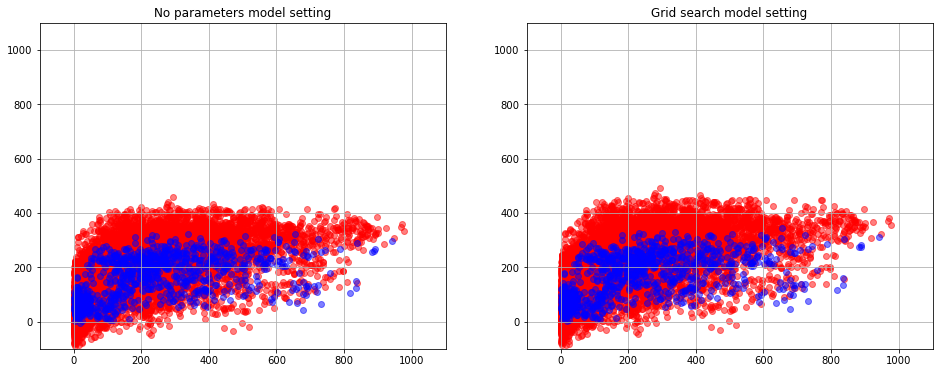

In [105]:
pylab.figure(figsize=(16, 6))
# No parameters model setting 
pylab.subplot(1,2,1)
pylab.grid(True)
pylab.scatter(train_labels, pipeline.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, pipeline.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('No parameters model setting')
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)

# Grid search model setting 
pylab.subplot(1,2,2)
pylab.grid(True)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('Grid search model setting')
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)

From the graph above we see that we have built a not very good model. 

We see that our point clouds does not look like a diagonal. Moreover, point clouds when using a model without parameter selection and point clouds when using a model with parameter selection are not of much differece. That is, our model is quite weak, and optimization by parameters did not profit much.  

### Conclusion
In this post we touched a baseline, that is an initial regression model that works only on numerical features. We learned how to do scaling, how to build transformation chains. 

In the followin posts we will try to improve this model by adding all the other features to it.